# Optimal Resource Planning
## Author: Snigdhayan Mahanta
Suppose a portfolio manager has 100 possible projects to choose from and 10 disciplines to execute the selected projects. The disciplines in turn have fixed human resources allocated to them limiting the total number of labor hours available per discipline. Let us assume that after some analysis the portfolio manager has the following information:

1. A numerical ranking of the projects according to some uniform scale (e.g., net present value)
2. For each project a resource request per discipine (number of labor hours)

What would be the optimal resource planning for the projects? For this purpose one can define an objective function to optimize the overall business value and then use solver to find an optimum solution. In what follows I performed a simulation and demonstrated how the results can fluctuate based on slightly different boundary conditions. 

REMARK: This approach makes an assumption that there is a linear correlation between the resource allocation of a project and the associated business value. This assumption is highly questionable in practice. Moreover, this particular problem is simple enough so that it can be solved directly in a top-down manner without using a complex optimization framework. However, as the complexity grows the optimization framework offers more flexibility to deal with them.

CAUTION: If the numerical rankings do not correspond to the relative expected project ROIs, then the computed optimum values below do not have a clear correlation with the overall portfolio values. Nevertheless, this methodology can be applied to allocate resources to optimize the overall business value from the projects.

In [1]:
from ortools.linear_solver import pywraplp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean, stdev

In [2]:
# Define the function to specify the linear optimization problem as a matrix multiplication
def create_data(shape):
    array1 = np.random.randint(low = 100, high = 500, size = shape) 
    matrix_coeffs = array1.tolist() # labor hour request per discipline (row) per project (column)
    constraints = np.random.randint(low = 100, high = 500, size = shape[0]) 
    constraints = constraints.tolist() # total available labor hours per discipline
    array2 = np.random.randint(low = 0, high = 100, size = shape[1]) 
    objective_coeffs = [(x*np.ones(shape[0])).tolist() for x in array2]
    objective_coeffs = list(map(list, zip(*objective_coeffs))) # coefficients of objective function
    ranking = {} 
    for i in range(1, len(array2)+1):
        ranking["Project_"+str(i)] = array2[i-1]
    ranking = dict(sorted(ranking.items(), key=lambda item: item[1], reverse = True)) # project ranking
    
    # Optimization parameters
    data = {}
    data['matrix_coeffs'] = matrix_coeffs
    data['constraints'] = constraints
    data['objective_coeffs'] = objective_coeffs

    # Other attributes
    data['n_constraints'] = len(constraints)
    data['n_rows'] = shape[0] # number of disciplines
    data['n_columns'] = shape[1] # number of projects
    data['ranking'] = ranking
    
    return data

In [3]:
# Create dataframe of the requested labor hours per project per discipline
def proj_disc_request(data):
    projects = ["Project_"+str(i+1) for i in range(data['n_columns'])]
    disciplines = ["Discipline_"+str(i+1) for i in range(data['n_rows'])]
    df = pd.DataFrame(data['matrix_coeffs'], columns=projects)
    df.insert(0, "Disciplines", disciplines)
    df['Total Labor Hours (Discipline)'] = data['constraints']
    return df

In [4]:
# Create a small sample dataset of the requested labor hours per project per discipline
sample_dataset = create_data((3,5)) # 3 disciplines and 5 projects
df = proj_disc_request(sample_dataset)
df

,Disciplines,Project_1,Project_2,Project_3,Project_4,Project_5,Total Labor Hours (Discipline)
0,Discipline_1,212,452,279,389,364,356
1,Discipline_2,469,152,284,243,179,315
2,Discipline_3,122,399,418,395,163,387


## Optimization Strategy
We are going to solve for the optimal fractional resource allocation based on a resource request structure as above. For each discipline the decision variable will solve for the fraction of the requested resource from each project that it will allocate. Hence the total number of decision variables is the product of the number of projects and the number of disciplines. 

In [5]:
# Define the optimization function; use the 'verbose' parameter to print the verbose result
def solve(data, verbose = 0):
    solver = pywraplp.Solver.CreateSolver('GLOP') # Create the linear solver with the GLOP backend
    # solver = pywraplp.Solver.CreateSolver('SCIP') # Create the mixed-integer programming solver with the SCIP backend
    infinity = solver.infinity()
    x = {}
    for i in range(data['n_rows']):
        for j in range(data['n_columns']):
            x[(i, j)] = solver.NumVar(0, 1, 'x_%i_%i' % (i, j))
    # print('Number of variables =', solver.NumVariables())

    for i in range(data['n_rows']):
        constraint = solver.RowConstraint(0, data['constraints'][i], '')
        for j in range(data['n_columns']):
            constraint.SetCoefficient(x[(i,j)], data['matrix_coeffs'][i][j])
    # print('Number of constraints =', solver.NumConstraints())

    objective = solver.Objective() # solve for the fraction of the requested resource that is actually allocated
    for i in range(data['n_rows']):
        for j in range(data['n_columns']):
            objective.SetCoefficient(x[(i,j)], data['objective_coeffs'][i][j])
            objective.SetMaximization()

    status = solver.Solve()
    portfolio_resource = 0
    optimum = -1
    solution_values = [[1 for j in range(data['n_columns'])] for i in range(data['n_rows'])]
    resource_allocations = [[1 for j in range(data['n_columns'])] for i in range(data['n_rows'])]
    if verbose == 1 and status == pywraplp.Solver.OPTIMAL:
        print(F'Overall optimum value = {round(solver.Objective().Value(), 2)}\n')
        portfolio_resource = round(sum(data['constraints']), 2)
        print(F'Overall portfolio resource = {portfolio_resource}\n')
        for i in range(data['n_rows']):
            for j in range(data['n_columns']):
                if x[(i,j)].solution_value() != 0: 
                    print(F'Discipline {i+1} - Project {j+1} Fraction Allocation = {round(x[(i,j)].solution_value(), 2)}\n')
        
        # print(F'Problem solved in %f milliseconds {round(solver.wall_time(), 2)}')
        # print(F'Problem solved in %d iterations {solver.iterations()}')
        # print(F'Problem solved in %d branch-and-bound nodes {solver.nodes()}')
        
    if verbose == 1 and status != pywraplp.Solver.OPTIMAL:
        print(F'The problem does not have an optimal solution.')
            
    if verbose == 0 and status == pywraplp.Solver.OPTIMAL:
        selected_projects = []
        optimum = solver.Objective().Value()
        portfolio_resource = sum(data['constraints'])
        for i in range(data['n_rows']):
            for j in range(data['n_columns']):
                if x[(i,j)].solution_value() != 0: selected_projects.append(j)
                solution_values[i][j] = solution_values[i][j]*x[(i,j)].solution_value()
                resource_allocations[i][j] = data['matrix_coeffs'][i][j]*solution_values[i][j]
        return optimum, portfolio_resource, solution_values, resource_allocations, list(set(selected_projects))
    
    if verbose == 0 and status != pywraplp.Solver.OPTIMAL:
        selected_projects = []
        portfolio_resource = sum(data['constraints'])
        return optimum, portfolio_resource, solution_values, resource_allocations, list(set(selected_projects))

In [6]:
# Define the simulation function
def simulate(shape, n_trials):
    optimum_values = []
    portfolio_resources = []
    resource_allocation_list = []
    selected_project_list = []
    unsolvable_trials = 0
    
    for i in range(n_trials):
        data = create_data(shape)
        optimum, portfolio_resource, solution_values, resource_allocations, selected_projects = solve(data, verbose = 0)
        if optimum == -1: unsolvable_trials += 1
        optimum_values.append(optimum)
        portfolio_resources.append(portfolio_resource)
        resource_allocation_list.append(resource_allocations)
        selected_project_list.append(selected_projects)
    return optimum_values, portfolio_resources, unsolvable_trials, resource_allocation_list, selected_project_list

In [7]:
# Define portfolio structure 
shape = (10, 100) # (number of disciplines, number of projects)

# Solve a sample problem - print optimum portfolio value, overall portfolio resource and project resource allocations
data = create_data(shape)
solve(data, verbose = 1)

Overall optimum value = 2153.73

Overall portfolio resource = 3082

Discipline 1 - Project 32 Fraction Allocation = 1.0

Discipline 1 - Project 44 Fraction Allocation = 1.0

Discipline 1 - Project 96 Fraction Allocation = 0.71

Discipline 2 - Project 28 Fraction Allocation = 1.0

Discipline 2 - Project 41 Fraction Allocation = 1.0

Discipline 2 - Project 44 Fraction Allocation = 0.02

Discipline 3 - Project 37 Fraction Allocation = 0.64

Discipline 3 - Project 69 Fraction Allocation = 1.0

Discipline 3 - Project 96 Fraction Allocation = 1.0

Discipline 4 - Project 26 Fraction Allocation = 1.0

Discipline 4 - Project 44 Fraction Allocation = 0.17

Discipline 5 - Project 14 Fraction Allocation = 1.0

Discipline 5 - Project 69 Fraction Allocation = 1.0

Discipline 5 - Project 79 Fraction Allocation = 0.52

Discipline 5 - Project 86 Fraction Allocation = 1.0

Discipline 6 - Project 26 Fraction Allocation = 0.28

Discipline 6 - Project 54 Fraction Allocation = 1.0

Discipline 6 - Project 88

In [8]:
# Look at top 10 projects and their ranking values
all_projects = data['ranking'].items()
top_projects = dict(list(all_projects)[:10])
top_projects

{'Project_35': 99,
 'Project_69': 97,
 'Project_37': 96,
 'Project_100': 96,
 'Project_12': 95,
 'Project_90': 95,
 'Project_44': 94,
 'Project_14': 93,
 'Project_54': 93,
 'Project_59': 91}

In [9]:
# Define simulation parameter and run the simulation
n_trials = 100 # number of simulation trials
values, resources, unsolvable_trials, resource_allocation_list, selected_project_list = simulate(shape, n_trials)

In [10]:
# Print simulation overview
print(F'# Discipines = {shape[0]}')
print(F'# Projects = {shape[1]}')
print(F'# Simulation Trials = {n_trials}') 
print(F'# Unsolvable Trials = {unsolvable_trials}') 

# Discipines = 10
# Projects = 100
# Simulation Trials = 100
# Unsolvable Trials = 0


In [11]:
# Print the mean and the standard deviation of optimum portfolio values
print(F'Mean of Portfolio Values = {round(mean(values), 2)}')
print(F'Standard Deviation of Portfolio Values = {round(stdev(values), 2)}')

Mean of Portfolio Values = 2109.23
Standard Deviation of Portfolio Values = 257.52


In [12]:
# Print the mean and the standard deviation of overall portfolio resources
print(F'Mean of Portfolio Resources = {round(mean(resources), 2)}')
print(F'Standard Deviation of Portfolio Resources = {round(stdev(resources), 2)}')

Mean of Portfolio Resources = 2992.16
Standard Deviation of Portfolio Resources = 362.17


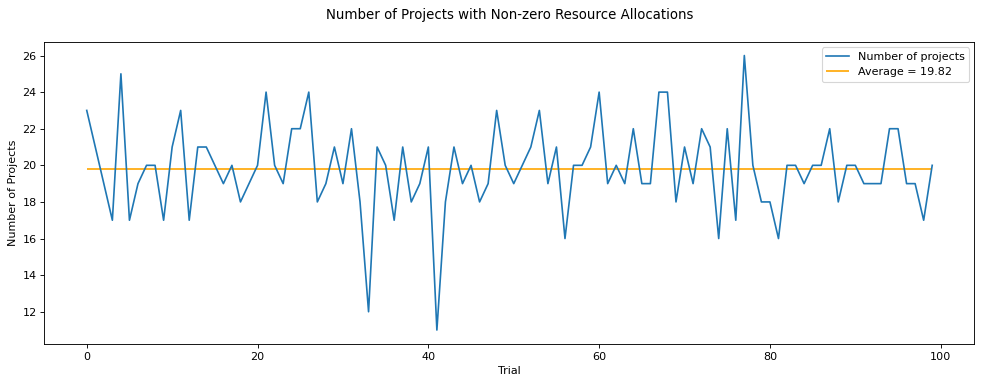

In [13]:
# Plot the number of projects with non-zero resource allocations

# x-axis values 
x = range(n_trials)
# y-axis values
y =  [len(x) for x in selected_project_list]
average = sum(y)/len(y)

# Plot the points
plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x, y)
plt.hlines(average, min(x), max(x), color='orange')

# x-axis name
plt.xlabel(F'Trial')

# y-axis name
plt.ylabel(F'Number of Projects')

# Title and legends
plt.title(F'Number of Projects with Non-zero Resource Allocations\n')

legends = [F'Number of projects', F'Average = {average}']
plt.legend(legends, loc='upper right')

plt.show()

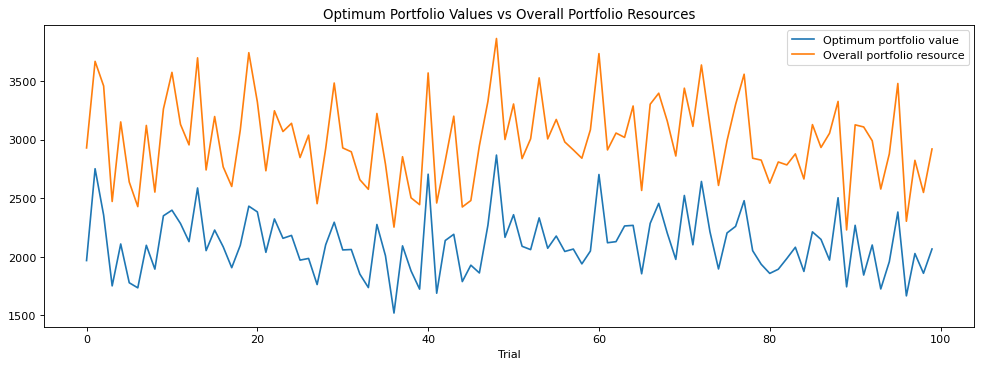

In [14]:
# Plot the optimum portfolio values and overall portfolio resources

# x-axis values 
x = range(n_trials)
# y-axis values 
y = values

# Plot the points 
plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x, y)


# x-axis values 
x = range(n_trials)
# y-axis values 
y = resources

# Plot the points
plt.plot(x, y)

# x-axis name
plt.xlabel(F'Trial') 

# Title and legends
plt.title(F'Optimum Portfolio Values vs Overall Portfolio Resources')

legends = [F'Optimum portfolio value', F'Overall portfolio resource']
plt.legend(legends, loc='upper right')

plt.show()

As mentioned earlier, in this mathematical model the computed optimum values do not admit a clear monetary interpretation.